In [ ]:
!nvidia-smi

Thu May 12 09:49:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import library

In [ ]:
from PIL import Image
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import math

# Get Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 145 kB 67.2 MB/s 
     |████████████████████████████████| 181 kB 26.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e005cce4c91d80db28da09a5ec1aa0a7e73733c227235bdc6b04cf68638bcc83
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Mounted at /content/gdrive/


In [ ]:
from glob import glob
train_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/maps/train/*')
val_file = glob(f'/content/gdrive/MyDrive/Colab Notebooks/maps/val/*')

In [ ]:
len(train_file), len(val_file)

(1096, 1098)

# Dataset Functions

In [ ]:
def get_file_name(file_path):
  return os.path.basename(file_path).split('.')[0]

In [ ]:
def getInputA(sample):
        C, H, W = sample.shape
        
        inputA = sample[:,:,:int(W/2)]
        
        return inputA

In [ ]:
def getInputB(sample):
        C, H, W = sample.shape
    
        inputB = sample[:,:,int(W/2):]
        
        return inputB

In [ ]:
def file_to_PIL(sample):
  
  result = Image.open(sample)

  return result

In [ ]:
def unnormalize(sample):
  sample = ((sample * 0.5) + 0.5)
  return sample

In [ ]:
def tensor_to_image(data):
  return  unnormalize(np.transpose(data.detach().cpu().numpy()[0] , (1, 2, 0)))

In [ ]:
def shuffle_batch(data):
  idx = torch.randperm(data.shape[0])
  data = data[idx].view(data.size())
  return data

# Dataset

In [ ]:
image_height = 256
image_width = 256

In [ ]:
class CustomDatasest(Dataset):
  def __init__(self, np_data, transform = None):
      self.data = np_data
      self.transform = transform
      self.len = len(np_data)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    sample = self.data[idx]
    file_name = get_file_name(sample)
    if self.transform:
      sample = self.transform(sample)
    return sample, str(file_name)

In [ ]:
transA = transforms.Compose([
                            file_to_PIL,
                            transforms.ToTensor(),
                            getInputA,
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                            transforms.Resize((image_height, image_width)),
                            transforms.RandomHorizontalFlip(),
                            ])

transB = transforms.Compose([
                            file_to_PIL,
                            transforms.ToTensor(),
                            getInputB,
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                            transforms.Resize((image_height, image_width)),
                            transforms.RandomHorizontalFlip(),
                            ])

#TMP_loader

In [ ]:
tmp = val_file[:60]
tmp_set_A = CustomDatasest(tmp, transform = transA)
tmp_loader_A = DataLoader(
    dataset = tmp_set_A, 
    batch_size = 1,
)
tmp_set_B = CustomDatasest(tmp, transform = transB)
tmp_loader_B = DataLoader(
    dataset = tmp_set_B, 
    batch_size = 1,
)

1006 1006
True
torch.Size([1, 3, 256, 256])


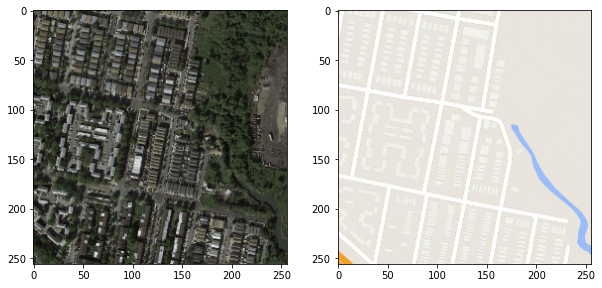

In [ ]:
a1, a2 = next(iter(tmp_loader_A))
b1, b2 = next(iter(tmp_loader_B))
fig = plt.figure(figsize=(10,20))
fig.add_subplot(121)
plt.imshow(tensor_to_image(a1))
fig.add_subplot(122)
plt.imshow(tensor_to_image(b1))
plt.show()

#parameter

In [ ]:
from tqdm import tqdm
from pytz import timezone
from datetime import datetime
now = datetime.now(timezone('Asia/Seoul'))
print(now)
BATCHSIZE = 1
EPOCHS = 200
lr = 0.0002

load_model = False
load_model_file_name = f''

wandb_resume = '' # If you want resume wandb, put project key

save_model = True
model_save_epoch = 10
model_root_folder = f'/content/gdrive/MyDrive/Colab Notebooks/maps/cyclegan_resnet/'
save_model_fileName = f'cyclegan_model_{now}.pth'
save_model_path = model_root_folder + save_model_fileName
load_model_file = model_root_folder + load_model_file_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2022-05-12 19:06:13.087174+09:00


#Data Loader

In [ ]:
train_A_set = CustomDatasest(train_file, transform = transA)
train_A_loader = DataLoader(
    dataset = train_A_set, 
    batch_size = BATCHSIZE,
    shuffle=True
)
train_B_set = CustomDatasest(train_file, transform = transB)
train_B_loader = DataLoader(
    dataset = train_B_set, 
    batch_size = BATCHSIZE,
    shuffle=True
)

#Model 구조 선언

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.Dropout(0.5),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

##Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_nc):
      super(Discriminator, self).__init__()

      # A bunch of convolutions one after another
      model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.5)]

      model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.5) ]

      model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.Dropout(0.5) ]

      model += [  nn.Conv2d(256, 512, 4, 1, 1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True) ]

      # FCN classification layer
      model += [nn.Conv2d(512, 1, 4, 1, 1)]

      self.model = nn.Sequential(*model)

  def forward(self, x):
    if self.training:
      noise = torch.randn(x.shape).to(x.device)
    x = x + noise
    return self.model(x)

## ReplayBuffer

In [ ]:
from torch.autograd import Variable
import random

class ReplayBuffer():
    def __init__(self, max_size=16):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return, 0)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.)

# Model 선언

In [ ]:
netG_A2B = Generator(3, 3)
netG_B2A = Generator(3, 3)
netD_A = Discriminator(3)
netD_B = Discriminator(3)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Loss Functions & optimizer

In [ ]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
g_parameters = list(netG_A2B.parameters()) + list(netG_B2A.parameters())
optimizer_G = torch.optim.Adam(g_parameters,
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 0.95 ** epoch,last_epoch=-1,verbose=False)

In [ ]:
device

device(type='cuda')

#Load Model

In [ ]:
start_epoch = 1
if load_model :
  checkpoint = torch.load(load_model_file, map_location=torch.device('cpu'))
  lr = checkpoint['lr']
  start_epoch = checkpoint['epoch']
  netG_A2B.load_state_dict(checkpoint['netG_A2B_state_dict'])
  netG_B2A.load_state_dict(checkpoint['netG_B2A_state_dict'])
  netD_A.load_state_dict(checkpoint['netD_A_state_dict'])
  netD_B.load_state_dict(checkpoint['netD_B_state_dict'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
  optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
  optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
  lr_scheduler_G.load_state_dict(checkpoint['lr_scheduler_G_state_dict'])
  lr_scheduler_D_A.load_state_dict(checkpoint['lr_scheduler_D_A_state_dict'])
  lr_scheduler_D_B.load_state_dict(checkpoint['lr_scheduler_D_B_state_dict'])
print(start_epoch)

# Test GAN

In [ ]:
iter_A = iter(tmp_loader_A)
iter_B = iter(tmp_loader_B)

netG_A2B.to(device)
netG_B2A.to(device)
netG_A2B.eval()
netG_B2A.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Dropout(p=0.5, inplace=False)
        (

In [ ]:
for _ in range(10):
  a1, a2 = next(iter_A)
  b1, b2 = next(iter_B)


  with torch.no_grad():
    inputA = a1.to(device)
    inputB = b1.to(device)

    fake_A = netG_B2A(inputB)
    fake_B = netG_A2B(inputA)
    
    tmp_fake_A = unnormalize(np.transpose(fake_A.detach().cpu().numpy()[0] , (1, 2, 0)))
    tmp_fake_B = unnormalize(np.transpose(fake_B.detach().cpu().numpy()[0] , (1, 2, 0)))
    tmp_input_A = unnormalize(np.transpose(inputA.detach().cpu().numpy()[0] , (1, 2, 0)))
    tmp_input_B = unnormalize(np.transpose(inputB.detach().cpu().numpy()[0] , (1, 2, 0)))


    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(141)
    plt.imshow(tmp_input_A)
    fig.add_subplot(142)
    plt.imshow(tmp_input_B)
    fig.add_subplot(143)
    plt.imshow(tmp_fake_A)
    fig.add_subplot(144)
    plt.imshow(tmp_fake_B)
    plt.show()

#wandb 설정

In [ ]:
!pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: nek0. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
  "learning_rate": lr,
  "epochs": EPOCHS,
  "batch_size": BATCHSIZE
}

wandb.init(project="Cyclegan ResNet", resume = wandb_resume)
if not wandb.run.resumed:
  wandb.run.name = 'Date : '+str(now)
wandb.config.update(config)

In [ ]:
wandb.run.name, wandb.run.resumed

('Date : 2022-05-12 02:46:50.888392+09:00', False)

#Train

In [ ]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
!nvidia-smi

Wed May 11 17:47:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   1117MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
iter_num = math.ceil(len(train_A_loader.dataset) / BATCHSIZE)
###################################
netG_A2B.train()
netG_B2A.train()
netD_A.train()
netD_B.train()

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

###### Training ######
for epoch in range(start_epoch, EPOCHS+1):
  progress_bar = tqdm(range(iter_num))

  train_A_iter = iter(train_A_loader)
  train_B_iter = iter(train_B_loader)

  befor_iter_same = False
  befor_iter_data = None

  loss_G_sum = 0
  loss_identity_A_sum = 0
  loss_identity_B_sum = 0
  loss_GAN_A2B_sum = 0
  loss_GAN_B2A_sum = 0
  loss_cycle_ABA_sum = 0
  loss_cycle_BAB_sum = 0
  loss_D_A_sum = 0
  loss_D_B_sum = 0

  for i in progress_bar:
      # Set model input

      input_A, image_name_A = next(train_A_iter)
      if not befor_iter_same:
        input_B, image_name_B = next(train_B_iter)
        if image_name_A[0] == image_name_B[0]:
          print(image_name_A[0], image_name_B[0])
          befor_iter_data = (input_B, image_name_B)
          input_B, image_name_B = next(train_B_iter)
          befor_iter_same = True
      else:
        print("CHNAGE")
        input_B, image_name_B = befor_iter_data
        befor_iter_data = None
        befor_iter_same = False

      

      real_A = input_A.to(device)
      real_B = input_B.to(device) # B

      ###### Generators A2B and B2A ######
      optimizer_G.zero_grad()

      # Identity loss
      same_B = netG_A2B(real_B)
      loss_identity_B = criterion_identity(same_B, real_B)*10.0
      loss_identity_B.backward()

      same_A = netG_B2A(real_A)
      loss_identity_A = criterion_identity(same_A, real_A)*10.0
      loss_identity_A.backward()

      # GAN loss
      fake_B = netG_A2B(real_A)
      pred_fake = netD_B(fake_B)

      target_real = torch.ones_like(pred_fake.detach(), requires_grad=False).to(device)
      target_fake = torch.zeros_like(pred_fake.detach(), requires_grad=False).to(device)

      loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

      recovered_A = netG_B2A(fake_B)
      loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0
      
      fake_loss_A2B = loss_GAN_A2B + loss_cycle_ABA
      fake_loss_A2B.backward()

      fake_A = netG_B2A(real_B)
      pred_fake = netD_A(fake_A)
      loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
      
      recovered_B = netG_A2B(fake_A)
      loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0
      
      fake_loss_B2A = loss_GAN_B2A + loss_cycle_BAB
      fake_loss_B2A.backward()
      
      optimizer_G.step()
      # Total loss
      loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
      ###################################

      ###### Discriminator A ######
      optimizer_D_A.zero_grad()

      # Real loss
      pred_real = netD_A(real_A)
      loss_D_real = criterion_GAN(pred_real, target_real)

      # Fake loss
      fake_A = fake_A_buffer.push_and_pop(fake_A)
      pred_fake = netD_A(fake_A.detach())
      loss_D_fake = criterion_GAN(pred_fake, target_fake)

      # Total loss
      loss_D_A = (loss_D_real + loss_D_fake)*0.5
      loss_D_A.backward()

      optimizer_D_A.step()
      ###################################

      ###### Discriminator B ######
      optimizer_D_B.zero_grad()

      # Real loss
      pred_real = netD_B(real_B)
      loss_D_real = criterion_GAN(pred_real, target_real)
      
      # Fake loss
      fake_B = fake_B_buffer.push_and_pop(fake_B)
      pred_fake = netD_B(fake_B.detach())
      loss_D_fake = criterion_GAN(pred_fake, target_fake)

      # Total loss
      loss_D_B = (loss_D_real + loss_D_fake)*0.5
      loss_D_B.backward()

      optimizer_D_B.step()
      ###################################
      loss_G_sum += (loss_G.item())
      loss_identity_A_sum += (loss_identity_A.item())
      loss_identity_B_sum += (loss_identity_B.item())
      loss_GAN_A2B_sum += (loss_GAN_A2B.item())
      loss_GAN_B2A_sum += (loss_GAN_B2A.item())
      loss_cycle_ABA_sum += (loss_cycle_ABA.item())
      loss_cycle_BAB_sum += (loss_cycle_BAB.item())
      loss_D_A_sum += (loss_D_A.item())
      loss_D_B_sum += (loss_D_B.item())

    # Update learning rates
  print('Epoch [{}/{}]' 
      .format(epoch, EPOCHS))
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()

  with torch.no_grad():
    tmp_A = real_A.to(device)
    tmp_B = real_B.to(device)
    tmp_fake_A = netG_B2A(tmp_B)
    tmp_fake_B = netG_A2B(tmp_A)
    tmp_cycled_A = netG_B2A(tmp_fake_B)
    tmp_cycled_B = netG_A2B(tmp_fake_A)

    wandb.log({
        "Input Image A": wandb.Image(tensor_to_image(tmp_A)),
        "Input Image B": wandb.Image(tensor_to_image(tmp_B)),
        "Generate Image A": wandb.Image(tensor_to_image(tmp_fake_A)),
        "Generate Image B": wandb.Image(tensor_to_image(tmp_fake_B)),
        "Cycled Image A": wandb.Image(tensor_to_image(tmp_cycled_A)),
        "Cycled Image B": wandb.Image(tensor_to_image(tmp_cycled_B)),
        "Total Generator loss": loss_G_sum / iter_num,
        "Identity loss A": loss_identity_A_sum / iter_num,
        "Identity loss B": loss_identity_B_sum / iter_num,
        "Gen loss AtoB": loss_GAN_A2B_sum / iter_num,
        "Gan loss BtoA": loss_GAN_B2A_sum / iter_num,
        "Cycle loss A": loss_cycle_ABA_sum / iter_num,
        "Cycle loss B":loss_cycle_BAB_sum / iter_num,
        "Total loss D_A": loss_D_A_sum / iter_num,
        "Total loss D_B": loss_D_B_sum / iter_num
    })

  if save_model and epoch % model_save_epoch == 0:
    torch.save({
              'netG_A2B_state_dict': netG_A2B.state_dict(),
              'netG_B2A_state_dict': netG_B2A.state_dict(),
              'netD_A_state_dict': netD_A.state_dict(),
              'netD_B_state_dict': netD_B.state_dict(),
              'optimizer_G_state_dict': optimizer_G.state_dict(),
              'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
              'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
              'lr_scheduler_G_state_dict': lr_scheduler_G.state_dict(),
              'lr_scheduler_D_A_state_dict': lr_scheduler_D_A.state_dict(),
              'lr_scheduler_D_B_state_dict': lr_scheduler_D_B.state_dict(),
              'lr': lr,
              'epoch': epoch,
              }, save_model_path)

 27%|██▋       | 295/1096 [01:57<04:40,  2.85it/s]

942 942


 27%|██▋       | 296/1096 [01:57<04:44,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:37<00:00,  2.76it/s]


Epoch [1/200]


 53%|█████▎    | 580/1096 [03:22<02:59,  2.87it/s]

13 13


 53%|█████▎    | 581/1096 [03:23<03:02,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [2/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [3/200]


 48%|████▊     | 531/1096 [03:05<03:16,  2.87it/s]

497 497


 49%|████▊     | 532/1096 [03:06<03:19,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [4/200]


 13%|█▎        | 139/1096 [00:48<05:32,  2.87it/s]

14 14


 13%|█▎        | 140/1096 [00:48<05:37,  2.83it/s]

CHNAGE


 20%|█▉        | 214/1096 [01:14<05:10,  2.84it/s]

790 790


 20%|█▉        | 215/1096 [01:15<05:15,  2.79it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [5/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [6/200]


 67%|██████▋   | 737/1096 [04:17<02:04,  2.87it/s]

49 49


 67%|██████▋   | 738/1096 [04:17<02:06,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [7/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [8/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [9/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [10/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [11/200]


 53%|█████▎    | 579/1096 [03:21<02:59,  2.87it/s]

1024 1024


 53%|█████▎    | 580/1096 [03:22<03:02,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [12/200]


 34%|███▍      | 371/1096 [02:09<04:11,  2.88it/s]

413 413


 34%|███▍      | 372/1096 [02:09<04:16,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [13/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [14/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [15/200]


  8%|▊         | 87/1096 [00:30<05:50,  2.88it/s]

902 902


  8%|▊         | 88/1096 [00:30<05:56,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [16/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [17/200]


 77%|███████▋  | 847/1096 [04:55<01:26,  2.87it/s]

594 594


 77%|███████▋  | 848/1096 [04:55<01:27,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [18/200]


 62%|██████▏   | 681/1096 [03:57<02:24,  2.86it/s]

638 638


 62%|██████▏   | 682/1096 [03:57<02:27,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [19/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [20/200]


 26%|██▌       | 287/1096 [01:40<04:42,  2.87it/s]

612 612


 26%|██▋       | 288/1096 [01:40<04:45,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [21/200]


 14%|█▍        | 156/1096 [00:54<05:27,  2.87it/s]

243 243


 14%|█▍        | 157/1096 [00:54<05:31,  2.83it/s]

CHNAGE


 21%|██        | 225/1096 [01:18<05:04,  2.86it/s]

115 115


 21%|██        | 226/1096 [01:18<05:07,  2.83it/s]

CHNAGE


 30%|███       | 334/1096 [01:56<04:24,  2.88it/s]

935 935


 31%|███       | 335/1096 [01:56<04:28,  2.84it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [22/200]


 49%|████▉     | 536/1096 [03:07<03:16,  2.86it/s]

850 850


 49%|████▉     | 537/1096 [03:07<03:17,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [23/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [24/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [25/200]


  5%|▍         | 54/1096 [00:18<06:03,  2.87it/s]

851 851


  5%|▌         | 55/1096 [00:19<06:08,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [26/200]


 85%|████████▌ | 937/1096 [05:26<00:55,  2.87it/s]

926 926


 86%|████████▌ | 938/1096 [05:27<00:55,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [27/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [28/200]


 11%|█▏        | 124/1096 [00:43<05:38,  2.87it/s]

1084 1084


 11%|█▏        | 125/1096 [00:43<05:42,  2.84it/s]

CHNAGE


 88%|████████▊ | 967/1096 [05:37<00:45,  2.86it/s]

1011 1011


 88%|████████▊ | 968/1096 [05:37<00:45,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [29/200]


 66%|██████▋   | 727/1096 [04:13<02:08,  2.88it/s]

682 682


 66%|██████▋   | 728/1096 [04:13<02:09,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:21<00:00,  2.87it/s]


Epoch [30/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [31/200]


  8%|▊         | 87/1096 [00:30<05:53,  2.86it/s]

563 563


  8%|▊         | 88/1096 [00:30<05:58,  2.81it/s]

CHNAGE


 66%|██████▌   | 718/1096 [04:10<02:11,  2.88it/s]

644 644


 66%|██████▌   | 719/1096 [04:10<02:13,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [32/200]


  2%|▏         | 25/1096 [00:08<06:13,  2.87it/s]

565 565


  2%|▏         | 26/1096 [00:09<06:19,  2.82it/s]

CHNAGE


 92%|█████████▏| 1006/1096 [05:50<00:31,  2.87it/s]

51 51


 92%|█████████▏| 1007/1096 [05:51<00:31,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [33/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [34/200]


 41%|████      | 447/1096 [02:35<03:46,  2.87it/s]

223 223


 41%|████      | 448/1096 [02:36<03:48,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [35/200]


  3%|▎         | 33/1096 [00:11<06:13,  2.85it/s]

645 645


  3%|▎         | 34/1096 [00:11<06:18,  2.81it/s]

CHNAGE


 16%|█▌        | 173/1096 [01:00<05:21,  2.87it/s]

959 959


 16%|█▌        | 174/1096 [01:00<05:25,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [36/200]


 35%|███▌      | 385/1096 [02:14<04:08,  2.86it/s]

153 153


 35%|███▌      | 386/1096 [02:14<04:11,  2.82it/s]

CHNAGE


 46%|████▋     | 507/1096 [02:56<03:25,  2.87it/s]

486 486


 46%|████▋     | 508/1096 [02:57<03:27,  2.83it/s]

CHNAGE


 82%|████████▏ | 896/1096 [05:12<01:09,  2.86it/s]

910 910


 82%|████████▏ | 897/1096 [05:12<01:10,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [37/200]


 16%|█▌        | 175/1096 [01:01<05:23,  2.85it/s]

101 101


 16%|█▌        | 176/1096 [01:01<05:30,  2.79it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [38/200]


 94%|█████████▎| 1027/1096 [05:58<00:24,  2.86it/s]

746 746


 94%|█████████▍| 1028/1096 [05:58<00:24,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [39/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [40/200]


 18%|█▊        | 192/1096 [01:07<05:14,  2.87it/s]

54 54


 18%|█▊        | 193/1096 [01:07<05:20,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [41/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [42/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [43/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [44/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [45/200]


 83%|████████▎ | 913/1096 [05:18<01:03,  2.86it/s]

158 158


 83%|████████▎ | 914/1096 [05:18<01:04,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [46/200]


 76%|███████▌  | 833/1096 [04:50<01:31,  2.87it/s]

181 181


 76%|███████▌  | 834/1096 [04:51<01:32,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [47/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [48/200]


 72%|███████▏  | 784/1096 [04:33<01:48,  2.87it/s]

184 184


 72%|███████▏  | 785/1096 [04:34<01:50,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [49/200]


 17%|█▋        | 191/1096 [01:06<05:14,  2.87it/s]

1043 1043


 18%|█▊        | 192/1096 [01:07<05:21,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [50/200]


 42%|████▏     | 455/1096 [02:38<03:42,  2.88it/s]

334 334


 42%|████▏     | 456/1096 [02:39<03:45,  2.83it/s]

CHNAGE


 77%|███████▋  | 841/1096 [04:53<01:29,  2.86it/s]

265 265


 77%|███████▋  | 842/1096 [04:53<01:29,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [51/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [52/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [53/200]


  8%|▊         | 83/1096 [00:28<05:52,  2.88it/s]

705 705


  8%|▊         | 84/1096 [00:29<05:56,  2.84it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [54/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [55/200]


  6%|▌         | 62/1096 [00:21<06:01,  2.86it/s]

1036 1036


  6%|▌         | 63/1096 [00:22<06:07,  2.81it/s]

CHNAGE


 99%|█████████▉| 1090/1096 [06:20<00:02,  2.88it/s]

730 730


100%|█████████▉| 1091/1096 [06:20<00:01,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [56/200]


 30%|███       | 331/1096 [01:55<04:28,  2.85it/s]

765 765


 30%|███       | 332/1096 [01:55<04:32,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [57/200]


 57%|█████▋    | 620/1096 [03:36<02:47,  2.85it/s]

431 431


 57%|█████▋    | 621/1096 [03:36<02:49,  2.81it/s]

CHNAGE


 69%|██████▉   | 758/1096 [04:24<01:58,  2.85it/s]

501 501


 69%|██████▉   | 759/1096 [04:24<02:00,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [58/200]


 87%|████████▋ | 951/1096 [05:31<00:50,  2.87it/s]

496 496


 87%|████████▋ | 952/1096 [05:32<00:51,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [59/200]


 22%|██▏       | 240/1096 [01:23<04:56,  2.88it/s]

287 287


 22%|██▏       | 241/1096 [01:24<05:02,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [60/200]


 88%|████████▊ | 965/1096 [05:36<00:45,  2.89it/s]

257 257


 88%|████████▊ | 966/1096 [05:37<00:45,  2.85it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [61/200]


  2%|▏         | 27/1096 [00:09<06:12,  2.87it/s]

767 767


  3%|▎         | 28/1096 [00:09<06:18,  2.82it/s]

CHNAGE


  6%|▌         | 67/1096 [00:23<05:57,  2.87it/s]

516 516


  6%|▌         | 68/1096 [00:23<06:04,  2.82it/s]

CHNAGE


  8%|▊         | 90/1096 [00:31<05:51,  2.86it/s]

529 529


  8%|▊         | 91/1096 [00:31<05:57,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [62/200]


 14%|█▍        | 154/1096 [00:53<05:26,  2.88it/s]

582 582


 14%|█▍        | 155/1096 [00:54<05:34,  2.82it/s]

CHNAGE


 92%|█████████▏| 1004/1096 [05:50<00:32,  2.86it/s]

844 844


 92%|█████████▏| 1005/1096 [05:50<00:32,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [63/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [64/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [65/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [66/200]


 41%|████      | 451/1096 [02:37<03:45,  2.86it/s]

359 359


 41%|████      | 452/1096 [02:37<03:48,  2.82it/s]

CHNAGE


 75%|███████▌  | 825/1096 [04:48<01:34,  2.86it/s]

873 873


 75%|███████▌  | 826/1096 [04:48<01:35,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [67/200]


 25%|██▍       | 269/1096 [01:33<04:49,  2.86it/s]

150 150


 25%|██▍       | 270/1096 [01:34<04:54,  2.80it/s]

CHNAGE


 33%|███▎      | 366/1096 [02:07<04:15,  2.85it/s]

151 151


 33%|███▎      | 367/1096 [02:08<04:20,  2.80it/s]

CHNAGE


 45%|████▍     | 489/1096 [02:50<03:30,  2.88it/s]

475 475


 45%|████▍     | 490/1096 [02:51<03:34,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [68/200]


  6%|▌         | 63/1096 [00:22<05:59,  2.87it/s]

16 16


  6%|▌         | 64/1096 [00:22<06:05,  2.82it/s]

CHNAGE


 86%|████████▌ | 938/1096 [05:27<00:55,  2.86it/s]

97 97


 86%|████████▌ | 939/1096 [05:27<00:55,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [69/200]


 73%|███████▎  | 800/1096 [04:39<01:43,  2.86it/s]

35 35


 73%|███████▎  | 801/1096 [04:39<01:44,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [70/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [71/200]


 26%|██▌       | 283/1096 [01:38<04:42,  2.88it/s]

670 670


 26%|██▌       | 284/1096 [01:39<04:45,  2.84it/s]

CHNAGE


 58%|█████▊    | 632/1096 [03:40<02:40,  2.88it/s]

347 347


 58%|█████▊    | 633/1096 [03:41<02:43,  2.84it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [72/200]


 66%|██████▌   | 722/1096 [04:12<02:09,  2.88it/s]

205 205


 66%|██████▌   | 723/1096 [04:12<02:11,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [73/200]


 38%|███▊      | 421/1096 [02:27<03:55,  2.87it/s]

566 566


 39%|███▊      | 422/1096 [02:27<03:58,  2.83it/s]

CHNAGE


 72%|███████▏  | 792/1096 [04:36<01:46,  2.86it/s]

459 459


 72%|███████▏  | 793/1096 [04:37<01:47,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [74/200]


 35%|███▌      | 388/1096 [02:15<04:06,  2.87it/s]

577 577


 35%|███▌      | 389/1096 [02:15<04:10,  2.83it/s]

CHNAGE


 85%|████████▍ | 927/1096 [05:23<00:58,  2.88it/s]

1069 1069


 85%|████████▍ | 928/1096 [05:24<00:59,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [75/200]


  9%|▉         | 101/1096 [00:35<05:48,  2.85it/s]

888 888


  9%|▉         | 102/1096 [00:35<05:52,  2.82it/s]

CHNAGE


 37%|███▋      | 405/1096 [02:21<04:01,  2.86it/s]

889 889


 37%|███▋      | 406/1096 [02:21<04:04,  2.83it/s]

CHNAGE


 59%|█████▉    | 652/1096 [03:47<02:35,  2.86it/s]

906 906


 60%|█████▉    | 653/1096 [03:48<02:36,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [76/200]


 58%|█████▊    | 635/1096 [03:41<02:41,  2.85it/s]

600 600


 58%|█████▊    | 636/1096 [03:42<02:44,  2.80it/s]

CHNAGE


 89%|████████▉ | 977/1096 [05:41<00:41,  2.88it/s]

235 235


 89%|████████▉ | 978/1096 [05:41<00:41,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [77/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [78/200]


 47%|████▋     | 516/1096 [03:00<03:21,  2.88it/s]

1001 1001


 47%|████▋     | 517/1096 [03:00<03:24,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [79/200]


 40%|████      | 443/1096 [02:34<03:47,  2.87it/s]

105 105


 41%|████      | 444/1096 [02:34<03:50,  2.83it/s]

CHNAGE


 46%|████▌     | 500/1096 [02:54<03:28,  2.85it/s]

876 876


 46%|████▌     | 501/1096 [02:54<03:31,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [80/200]


 41%|████      | 451/1096 [02:37<03:48,  2.82it/s]

1032 1032


 41%|████      | 452/1096 [02:37<03:53,  2.76it/s]

CHNAGE


 45%|████▍     | 492/1096 [02:51<03:30,  2.87it/s]

545 545


 45%|████▍     | 493/1096 [02:52<03:32,  2.84it/s]

CHNAGE


 50%|████▉     | 545/1096 [03:10<03:12,  2.87it/s]

737 737


 50%|████▉     | 546/1096 [03:10<03:15,  2.81it/s]

CHNAGE


 71%|███████   | 776/1096 [04:31<01:51,  2.87it/s]

51 51


 71%|███████   | 777/1096 [04:31<01:53,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [81/200]


 71%|███████   | 774/1096 [04:30<01:52,  2.87it/s]

834 834


 71%|███████   | 775/1096 [04:30<01:53,  2.83it/s]

CHNAGE


 75%|███████▍  | 818/1096 [04:45<01:37,  2.85it/s]

778 778


 75%|███████▍  | 819/1096 [04:46<01:38,  2.81it/s]

CHNAGE


 75%|███████▌  | 827/1096 [04:48<01:33,  2.86it/s]

311 311


 76%|███████▌  | 828/1096 [04:49<01:34,  2.83it/s]

CHNAGE


 97%|█████████▋| 1066/1096 [06:12<00:10,  2.85it/s]

409 409


 97%|█████████▋| 1067/1096 [06:12<00:10,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [82/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [83/200]


 74%|███████▍  | 815/1096 [04:44<01:38,  2.86it/s]

571 571


 74%|███████▍  | 816/1096 [04:45<01:39,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [84/200]


 17%|█▋        | 183/1096 [01:03<05:20,  2.85it/s]

1035 1035


 17%|█▋        | 184/1096 [01:04<05:25,  2.80it/s]

CHNAGE


 46%|████▌     | 505/1096 [02:56<03:25,  2.88it/s]

973 973


 46%|████▌     | 506/1096 [02:56<03:29,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [85/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [86/200]


 37%|███▋      | 410/1096 [02:23<03:58,  2.87it/s]

184 184


 38%|███▊      | 411/1096 [02:23<04:02,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [87/200]


 23%|██▎       | 252/1096 [01:27<04:53,  2.87it/s]

428 428


 23%|██▎       | 253/1096 [01:28<04:59,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [88/200]


  4%|▍         | 47/1096 [00:16<06:07,  2.86it/s]

165 165


  4%|▍         | 48/1096 [00:16<06:13,  2.80it/s]

CHNAGE


 76%|███████▌  | 835/1096 [04:51<01:30,  2.87it/s]

429 429


 76%|███████▋  | 836/1096 [04:51<01:32,  2.82it/s]

CHNAGE


 88%|████████▊ | 968/1096 [05:37<00:44,  2.87it/s]

885 885


 88%|████████▊ | 969/1096 [05:38<00:45,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [89/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [90/200]


 20%|██        | 220/1096 [01:16<05:05,  2.86it/s]

748 748


 20%|██        | 221/1096 [01:17<05:10,  2.82it/s]

CHNAGE


 40%|███▉      | 434/1096 [02:31<03:50,  2.87it/s]

204 204


 40%|███▉      | 435/1096 [02:31<03:53,  2.83it/s]

CHNAGE


 44%|████▍     | 482/1096 [02:48<03:35,  2.85it/s]

587 587


 44%|████▍     | 483/1096 [02:48<03:37,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [91/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [92/200]


 54%|█████▍    | 591/1096 [03:26<02:55,  2.87it/s]

464 464


 54%|█████▍    | 592/1096 [03:26<02:59,  2.81it/s]

CHNAGE


 87%|████████▋ | 957/1096 [05:33<00:48,  2.86it/s]

518 518


 87%|████████▋ | 958/1096 [05:34<00:48,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [93/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [94/200]


 27%|██▋       | 297/1096 [01:43<04:38,  2.87it/s]

78 78


 27%|██▋       | 298/1096 [01:43<04:40,  2.84it/s]

CHNAGE


 58%|█████▊    | 634/1096 [03:41<02:42,  2.85it/s]

57 57


 58%|█████▊    | 635/1096 [03:41<02:44,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [95/200]


 37%|███▋      | 404/1096 [02:21<04:01,  2.87it/s]

642 642


 37%|███▋      | 405/1096 [02:21<04:04,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [96/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [97/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.87it/s]


Epoch [98/200]


 55%|█████▍    | 599/1096 [03:28<02:53,  2.87it/s]

798 798


 55%|█████▍    | 600/1096 [03:29<02:54,  2.84it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [99/200]


 74%|███████▍  | 815/1096 [04:44<01:37,  2.87it/s]

725 725


 74%|███████▍  | 816/1096 [04:45<01:39,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [100/200]


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [101/200]


 91%|█████████▏| 1001/1096 [05:49<00:33,  2.87it/s]

110 110


 91%|█████████▏| 1002/1096 [05:49<00:33,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [102/200]


 44%|████▎     | 477/1096 [02:46<03:36,  2.86it/s]

714 714


 44%|████▎     | 478/1096 [02:46<03:39,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [103/200]


 21%|██        | 230/1096 [01:20<05:01,  2.87it/s]

244 244


 21%|██        | 231/1096 [01:20<05:06,  2.83it/s]

CHNAGE


 48%|████▊     | 530/1096 [03:05<03:17,  2.87it/s]

377 377


 48%|████▊     | 531/1096 [03:05<03:20,  2.82it/s]

CHNAGE


 61%|██████    | 665/1096 [03:52<02:30,  2.86it/s]

1048 1048


 61%|██████    | 666/1096 [03:52<02:33,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [104/200]


 30%|██▉       | 325/1096 [01:53<04:28,  2.87it/s]

1080 1080


 30%|██▉       | 326/1096 [01:53<04:32,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [105/200]


 80%|████████  | 881/1096 [05:07<01:14,  2.87it/s]

102 102


 80%|████████  | 882/1096 [05:08<01:15,  2.82it/s]

CHNAGE


100%|█████████▉| 1092/1096 [06:21<00:01,  2.87it/s]

987 987


100%|█████████▉| 1093/1096 [06:21<00:01,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [106/200]


 23%|██▎       | 257/1096 [01:29<04:53,  2.86it/s]

373 373


 24%|██▎       | 258/1096 [01:30<04:57,  2.82it/s]

CHNAGE


 77%|███████▋  | 843/1096 [04:54<01:27,  2.88it/s]

417 417


 77%|███████▋  | 844/1096 [04:54<01:29,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [107/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [108/200]


 34%|███▍      | 374/1096 [02:10<04:12,  2.86it/s]

130 130


 34%|███▍      | 375/1096 [02:10<04:15,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [109/200]


  1%|          | 12/1096 [00:04<06:19,  2.86it/s]

1011 1011


  1%|          | 13/1096 [00:04<06:22,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [110/200]


  5%|▍         | 50/1096 [00:17<06:05,  2.86it/s]

862 862


  5%|▍         | 51/1096 [00:17<06:10,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:22<00:00,  2.86it/s]


Epoch [111/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [112/200]


 50%|█████     | 549/1096 [03:11<03:09,  2.88it/s]

738 738


 50%|█████     | 550/1096 [03:12<03:12,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [113/200]


  0%|          | 4/1096 [00:01<06:23,  2.84it/s]

992 992


  0%|          | 5/1096 [00:01<06:29,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [114/200]


 30%|███       | 333/1096 [01:56<04:26,  2.87it/s]

1041 1041


 30%|███       | 334/1096 [01:56<04:30,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [115/200]


 38%|███▊      | 416/1096 [02:25<03:57,  2.86it/s]

1090 1090


 38%|███▊      | 417/1096 [02:25<04:00,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [116/200]


 65%|██████▌   | 715/1096 [04:10<02:13,  2.86it/s]

299 299


 65%|██████▌   | 716/1096 [04:10<02:15,  2.81it/s]

CHNAGE


 95%|█████████▍| 1040/1096 [06:03<00:19,  2.85it/s]

1028 1028


 95%|█████████▍| 1041/1096 [06:04<00:19,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [117/200]


 79%|███████▉  | 871/1096 [05:04<01:18,  2.87it/s]

728 728


 80%|███████▉  | 872/1096 [05:04<01:19,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [118/200]


 11%|█         | 118/1096 [00:41<05:39,  2.88it/s]

813 813


 11%|█         | 119/1096 [00:41<05:45,  2.83it/s]

CHNAGE


 26%|██▋       | 289/1096 [01:41<04:42,  2.86it/s]

343 343


 26%|██▋       | 290/1096 [01:41<04:46,  2.82it/s]

CHNAGE


 40%|████      | 439/1096 [02:33<03:49,  2.86it/s]

445 445


 40%|████      | 440/1096 [02:33<03:53,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [119/200]


 63%|██████▎   | 691/1096 [04:01<02:21,  2.87it/s]

1006 1006


 63%|██████▎   | 692/1096 [04:02<02:22,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [120/200]


 55%|█████▌    | 607/1096 [03:32<02:52,  2.84it/s]

1040 1040


 55%|█████▌    | 608/1096 [03:32<02:53,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [121/200]


 50%|█████     | 553/1096 [03:13<03:10,  2.86it/s]

813 813


 51%|█████     | 554/1096 [03:13<03:12,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [122/200]


 81%|████████▏ | 891/1096 [05:11<01:11,  2.86it/s]

989 989


 81%|████████▏ | 892/1096 [05:12<01:13,  2.79it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [123/200]


 13%|█▎        | 143/1096 [00:50<05:33,  2.86it/s]

51 51


 13%|█▎        | 144/1096 [00:50<05:39,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [124/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [125/200]


 87%|████████▋ | 953/1096 [05:33<00:50,  2.86it/s]

411 411


 87%|████████▋ | 954/1096 [05:33<00:50,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [126/200]


 30%|███       | 329/1096 [01:55<04:27,  2.86it/s]

462 462


 30%|███       | 330/1096 [01:55<04:31,  2.83it/s]

CHNAGE


 77%|███████▋  | 844/1096 [04:55<01:27,  2.87it/s]

330 330


 77%|███████▋  | 845/1096 [04:55<01:28,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [127/200]


 81%|████████  | 889/1096 [05:10<01:12,  2.86it/s]

243 243


 81%|████████  | 890/1096 [05:11<01:13,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [128/200]


 59%|█████▉    | 647/1096 [03:46<02:37,  2.86it/s]

892 892


 59%|█████▉    | 648/1096 [03:46<02:39,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [129/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [130/200]


 62%|██████▏   | 681/1096 [03:58<02:25,  2.84it/s]

631 631


 62%|██████▏   | 682/1096 [03:58<02:27,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [131/200]


 12%|█▏        | 133/1096 [00:46<05:37,  2.86it/s]

541 541


 12%|█▏        | 134/1096 [00:46<05:43,  2.80it/s]

CHNAGE


 38%|███▊      | 421/1096 [02:27<03:55,  2.87it/s]

693 693


 39%|███▊      | 422/1096 [02:27<03:58,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [132/200]


 98%|█████████▊| 1077/1096 [06:16<00:06,  2.85it/s]

98 98


 98%|█████████▊| 1078/1096 [06:17<00:06,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [133/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [134/200]


 21%|██        | 228/1096 [01:19<05:03,  2.86it/s]

188 188


 21%|██        | 229/1096 [01:20<05:09,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [135/200]


 96%|█████████▋| 1056/1096 [06:09<00:14,  2.86it/s]

500 500


 96%|█████████▋| 1057/1096 [06:09<00:13,  2.82it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [136/200]


 57%|█████▋    | 626/1096 [03:39<02:44,  2.85it/s]

985 985


 57%|█████▋    | 627/1096 [03:39<02:46,  2.81it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [137/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [138/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [139/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [140/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [141/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [142/200]


 47%|████▋     | 511/1096 [02:58<03:25,  2.84it/s]

163 163


 47%|████▋     | 512/1096 [02:59<03:28,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [143/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [144/200]


 93%|█████████▎| 1016/1096 [05:55<00:27,  2.87it/s]

126 126


 93%|█████████▎| 1017/1096 [05:55<00:27,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [145/200]


 91%|█████████▏| 1002/1096 [05:50<00:32,  2.87it/s]

691 691


 92%|█████████▏| 1003/1096 [05:50<00:32,  2.83it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [146/200]


  1%|          | 11/1096 [00:03<06:18,  2.87it/s]

262 262


  1%|          | 12/1096 [00:04<06:23,  2.83it/s]

CHNAGE


 21%|██        | 232/1096 [01:21<05:05,  2.83it/s]

633 633


 21%|██▏       | 233/1096 [01:21<05:10,  2.78it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [147/200]


 20%|██        | 223/1096 [01:18<05:05,  2.86it/s]

722 722


 20%|██        | 224/1096 [01:18<05:10,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [148/200]


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [149/200]


 11%|█         | 122/1096 [00:42<05:41,  2.85it/s]

603 603


 11%|█         | 123/1096 [00:43<05:45,  2.82it/s]

CHNAGE


 47%|████▋     | 511/1096 [02:58<03:24,  2.85it/s]

793 793


 47%|████▋     | 512/1096 [02:59<03:27,  2.82it/s]

CHNAGE


 69%|██████▉   | 755/1096 [04:24<01:59,  2.86it/s]

14 14


 69%|██████▉   | 756/1096 [04:24<02:01,  2.80it/s]

CHNAGE


100%|██████████| 1096/1096 [06:23<00:00,  2.86it/s]


Epoch [150/200]


  3%|▎         | 29/1096 [00:10<06:15,  2.84it/s]

523 523


  3%|▎         | 30/1096 [00:10<06:21,  2.79it/s]

CHNAGE


 58%|█████▊    | 638/1096 [03:43<02:40,  2.86it/s]


KeyboardInterrupt: ignored

In [ ]:
    torch.save({
              'netG_A2B_state_dict': netG_A2B.state_dict(),
              'netG_B2A_state_dict': netG_B2A.state_dict(),
              'netD_A_state_dict': netD_A.state_dict(),
              'netD_B_state_dict': netD_B.state_dict(),
              'optimizer_G_state_dict': optimizer_G.state_dict(),
              'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
              'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
              'lr_scheduler_G_state_dict': lr_scheduler_G.state_dict(),
              'lr_scheduler_D_A_state_dict': lr_scheduler_D_A.state_dict(),
              'lr_scheduler_D_B_state_dict': lr_scheduler_D_B.state_dict(),
              'lr': lr,
              'epoch': epoch,
              }, save_model_path+f"_200epochs.pth")